# Ordinary Differential Equation Solvers: Runge-Kutta Methods
### Christina Lee
### Category: Numerics

So what's an <i>Ordinary Differential Equation</i>?

Differential Equation means we have some equation (or equations) that have derivatives in them.  

The <i>ordinary</i> part differentiates them from <i>partial</i> differential equations (the ones with curly $\partial$ derivatives).  Here, we only have one <b>independent</b> variable (let's call it $t$), and one or more <b>dependent</b>  variables (let's call them $x_1, x_2, ...$).  In partial differential equations, we can have more than one independent variable.

This ODE can either be written as a system of the form
$$
\frac{d x_1}{dt}=f_1(t,x_1,x_2,...,x_n)
$$
$$
\frac{d x_2}{dt}=f_2(t,x_1,x_2,...,x_n)
$$
...
$$
\frac{d x_n}{dt}=f_n(t,x_1,x_n,...,x_n)
$$
or a single n'th order ODE of the form
$$
f_n(t,x) \frac{d^n x}{dt^n}+...+f_1(t,x) \frac{dx}{dt}+f_0(t,x)=0
$$
that can be rewritten in terms of a system of first order equations by performing variable substitutions such as
$$
\frac{d^i x}{dt^i}=x_i
$$

Though STEM students such as I have probably spent thousands of hours pouring of ways to analytically solve both ordinary and partial differential equations, unfortunately, the real world is rarely so kind as to provide us with an exactly solvable differential equation.  At least for interesting problems.  

We can sometimes approximate the real world as an exactly solvable situation, but for the situation we are interested in, we have to turn to numerics.  I'm not saying those thousand different analytic methods are for nothing.  We need an idea ahead of time of what the differential equation should be doing, to tell if it's misbehaving or not.  We can't just blindly plug and chug.  

Today will be about introducing four different methods based on Taylor expansion to a specific order, also known as Runge-Kutta Methods.  We can improve these methods with adaptive stepsize control, but that is a topic for another time, just like the other modern types of solvers such as Richardson extrapolation and predictor-corrector.  

Nonetheless, to work with ANY computational differential equation solver, you need to understand the fundamentals of routines like Euler and Runge-Kutta, their error propagation, and where they can go wrong. Otherwise, you might misinterpret the results of more advanced methods. 

<b>WARNING:</b> If you need to solve a troublesome differential equation for a research problem, use a package, like [DifferentialEquations](https://github.com/JuliaDiffEq/DifferentialEquations.jl).  These packages have much better error handling and optimization.

Let's first add our plotting package and colors.

In [1]:
using Plots
gr()

Plots.GRBackend()

We will be benchmarking our solvers on one of the simplest and most common ODE's,

\begin{equation}
\frac{d}{d t}x=x \;\;\;\;\;\;\; x(t)=C e^t
\end{equation}

Though this only has one dependent variable, we want to structure our code so that we can accommodate a series of dependent variables, $x_1,x_2,...,x_n$, and their associated derivative functions.  Therefore, we create a function for each dependent variable, and then `push` it into an array declared as type `Function`.

In [2]:
function f1(t::Float64,x::Array{Float64,1})
    return x[1]
end
f=Function[]
push!(f,f1)


1-element Array{Function,1}:
 f1

### Euler's Method

<img src="../images/ODE/graphic.png" width="400" alt="Euler Step" />

First published in Euler's <i>Instutionum calculi integralis</i> in 1768, this method gets a lot of milage, and if you are to understand anything, this method is it.  

We march along with step size $h$, and at each new point, calculate the slope.  The slope gives us our new direction to travel for the next $h$.

We can determine the error from the Taylor expansion of the function
$$
x_{n+1}=x_n+h f(x_n,t) + \mathcal{O}(h^2).
$$
In case you haven't seen it before, the notation $\mathcal{O}(x)$ stands for "errors of the order x".
Summing over the entire interval, we accumuluate error according to 
$$N\mathcal{O}(h^2)= \frac{x_f-x_0}{h}\mathcal{O}(h^2)=h, $$
making this a <b>first order</b> method.  Generally, if a technique is $n$th order in the Taylor expansion for one step, its $(n-1)$th order over the interval. 

In [3]:
function Euler(f::Array{Function,1},t0::Float64,x::Array{Float64,1},h::Float64)
    d=length(f)
    xp=copy(x)
    for ii in 1:d
        xp[ii]+=h*f[ii](t0,x)
    end
    
    return t0+h,xp
end

Euler (generic function with 1 method)

## Implicit Method or Backward Euler


If $f(t,x)$ has a form that is invertible, we can form a specific expression for the next step.  For example, if we use our exponential,
\begin{equation}
x_{n+1}=x_n+ h f(t_{n+1},x_{n+1})
\end{equation}
\begin{equation}
x_{n+1}-h x_{n+1}=x_n
\end{equation}
\begin{equation}
x_{n+1}=\frac{x_n}{1-h}
\end{equation}

This expression varies for each differential equation and only exists if the function is invertible.

In [4]:
function Implicit(f::Array{Function,1},t0::Float64,x::Array{Float64,1},h::Float64)
    return t0+h,[ x[1]/(1-h) ]
end

Implicit (generic function with 1 method)

## 2nd Order Runge-Kutta

So in the Euler Method, we could just make more, tinier steps to achieve more precise results. Here, we make <i>bettter</i> steps.  Each step itself takes more work than a step in the first order methods, but we win by having to perform fewer steps.

This time, we are going to work with the Taylor expansion up to second order,
\begin{equation}
x_{n+1}=x_n+h f(t_n,x_n) + \frac{h^2}{2} f^{\prime}(t_n,x_n)+ \mathcal{O} (h^3).
\end{equation}

Define
\begin{equation}
k_1=f(t_n,x_n),
\end{equation}
so that we can write down the derivative of our $f$ function, and the second derivative (curvature), of our solution,
\begin{equation}
f^{\prime}(t_n,x_n)=\frac{f(t_n+h/2,x_n+h k_1/2)-k_1}{h/2}+\mathcal{O}(h^2).
\end{equation}
Plugging this expression back into our Taylor expanion, we get a new expression for $x_{n+1}$
\begin{equation}
x_{n+1}=x_n+hf(t_n+h/2,x_n+h k_1/2)+\mathcal{O}(h^3)
\end{equation}

We can also interpret this technique as using the slope at the center of the interval, instead of the start.

In [5]:
function RK2(f::Array{Function,1},t0::Float64,x::Array{Float64,1},h::Float64)
    d=length(f)

    xp=copy(x)
    xk1=copy(x)
    
    for ii in 1:d
        xk1[ii]+=f[ii](t0,x)*h/2
    end
    for ii in 1:d
        xp[ii]+=f[ii](t0+h/2,xk1)*h 
    end
    
    return t0+h,xp
end

RK2 (generic function with 1 method)

## 4th Order Runge-Kutta
Wait! Where's 3rd order? There exists a 3rd order method, but I only just heard about it while fact-checking for this post.  RK4 is your dependable, multi-purpose workhorse, so we are going to skip right to it.  

$$
k_1= f(t_n,x_n)
$$
$$
k_2= f(t_n+h/2,x_n+h k_1/2)
$$
$$
k_3 = f(t_n+h/2, x_n+h k_2/2)
$$
$$
k_4 = f(t_n+h,x_n+h k_3)
$$
$$
x_{n+1}=x_n+\frac{h}{6}\left(k_1+2 k_2+ 2k_3 +k_4 \right)
$$
I'm not going to prove here that the method is fourth order, but we will see numerically that it is.

<i>Note:</i> I premultiply the $h$ in my code to reduce the number of times I have to multiply $h$.

In [6]:
function RK4(f::Array{Function,1},t0::Float64,x::Array{Float64,1},h::Float64)
    d=length(f)
    
    hk1=zeros(Float64,length(x))
    hk2=zeros(Float64,length(x))
    hk3=zeros(Float64,length(x))
    hk4=zeros(Float64,length(x))
    
    
    for ii in 1:d
        hk1[ii]=h*f[ii](t0,x)
    end
    for ii in 1:d
        hk2[ii]=h*f[ii](t0+h/2,x+hk1/2)
    end
    for ii in 1:d
        hk3[ii]=h*f[ii](t0+h/2,x+hk2/2) 
    end
    for ii in 1:d
        hk4[ii]=h*f[ii](t0+h,x+hk3)
    end
    
    return t0+h,x+(hk1+2*hk2+2*hk3+hk4)/6
end

RK4 (generic function with 1 method)

This next function merely iterates over a certain number of steps for a given method.  

In [7]:
function Solver(f::Array{Function,1},Method::Function,t0::Float64,
        x0::Array{Float64,1},h::Float64,N::Int64)
    d=length(f)
    ts=zeros(Float64,N+1)
    xs=zeros(Float64,d,N+1)
    
    ts[1]=t0
    xs[:,1]=x0
    
    for i in 2:(N+1)
        ts[i],xs[:,i]=Method(f,ts[i-1],xs[:,i-1],h)
    end
    
    return ts,xs
end

Solver (generic function with 1 method)

In [8]:
N=1000
xf=10
t0=0.
x0=[1.]
dt=(xf-t0)/N

tEU,xEU=Solver(f,Euler,t0,x0,dt,N);
tIm,xIm=Solver(f,Implicit,t0,x0,dt,N);
tRK2,xRK2=Solver(f,RK2,t0,x0,dt,N);
tRK4,xRK4=Solver(f,RK4,t0,x0,dt,N);

xi=tEU
yi=exp.(xi);

errEU=reshape(xEU[1,:],N+1)-yi
errIm=reshape(xIm[1,:],N+1)-yi
errRK2=reshape(xRK2[1,:],N+1)-yi;
errRK4=reshape(xRK4[1,:],N+1)-yi;

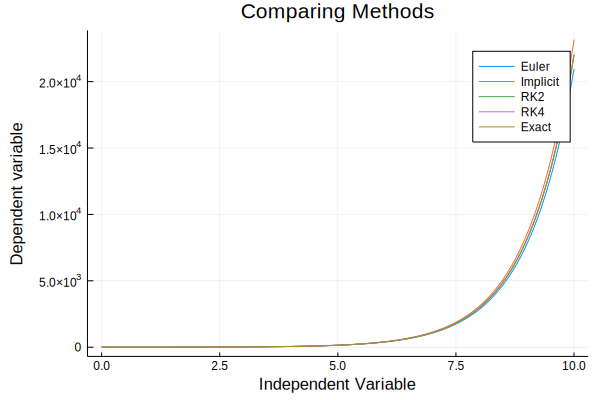

In [9]:
plot(tEU,xEU[1,:],label="Euler")
plot!(tIm,xIm[1,:],label="Implicit")
plot!(tRK2,xRK2[1,:],label="RK2")
plot!(tRK4,xRK4[1,:],label="RK4")
plot!(xi,yi,label="Exact")
plot!(xlabel="Independent Variable",ylabel="Dependent variable",title="Comparing Methods")

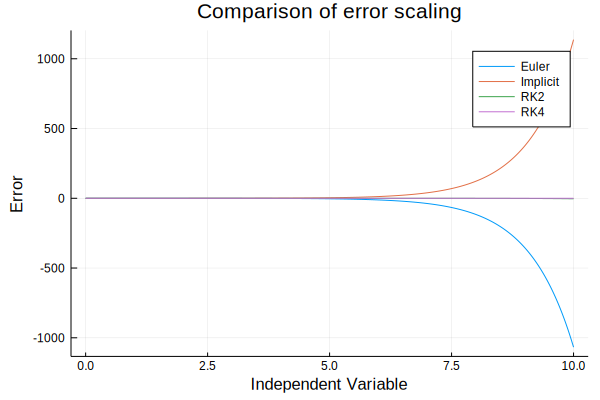

In [10]:
plot(xi,errEU,label="Euler")
plot!(xi,errIm,label="Implicit")
plot!(xi,errRK2,label="RK2")
plot!(xi,errRK4,label="RK4")
plot!(xlabel="Independent Variable",ylabel="Error",title="Comparison of error scaling")

## Scaling of the Error 

I talked above about the error scaling either as $h,h^2$, or $h^4$.  I won't just talk but here will numerically demonstrate the relationship as well.  For a variety of different step sizes, the below code calculates the final error for each method.  Then we will plot the error and see how it scales.

In [12]:
t0=0.
tf=1.
dx=tf-t0
x0=[1.]

dt=collect(.001:.0001:.01)

correctans=exp(tf)
errfEU=zeros(Float64,length(dt))
errfIm=zeros(Float64,length(dt))
errfRK2=zeros(Float64,length(dt))
errfRK4=zeros(Float64,length(dt))



for ii in 1:length(dt)
    N=round(Int,dx/dt[ii])
    dt[ii]=dx/N
    
    tEU,xEU=Solver(f,Euler,t0,x0,dt[ii],N);
    tIm,xIm=Solver(f,Implicit,t0,x0,dt[ii],N);
    tRK2,xRK2=Solver(f,RK2,t0,x0,dt[ii],N);
    tRK4,xRK4=Solver(f,RK4,t0,x0,dt[ii],N);
    
    errfEU[ii]=xEU[1,end]-correctans
    errfIm[ii]=xIm[1,end]-correctans
    errfRK2[ii]=xRK2[1,end]-correctans
    errfRK4[ii]=xRK4[1,end]-correctans
end

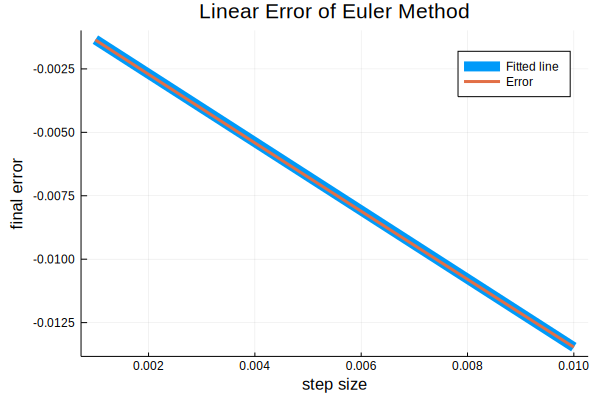

In [13]:
plot(x->errfEU[end]*x/.01,dt[1],dt[end],label="Fitted line",
    linewidth=10)
plot!(dt,errfEU,label="Error",linewidth=3)

plot!(xlabel="step size",ylabel="final error",
    title="Linear Error of Euler Method")

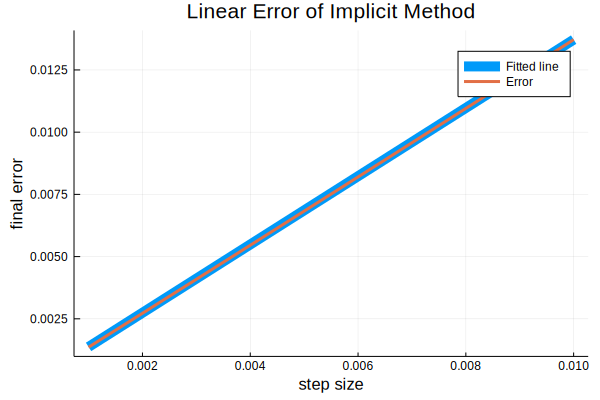

In [14]:
plot(x->errfIm[end]*x/.01,dt[1],dt[end],label="Fitted line",
    linewidth=10)
plot!(dt,errfIm,label="Error",linewidth=3)
plot!(xlabel="step size",ylabel="final error",
    title="Linear Error of Implicit Method")


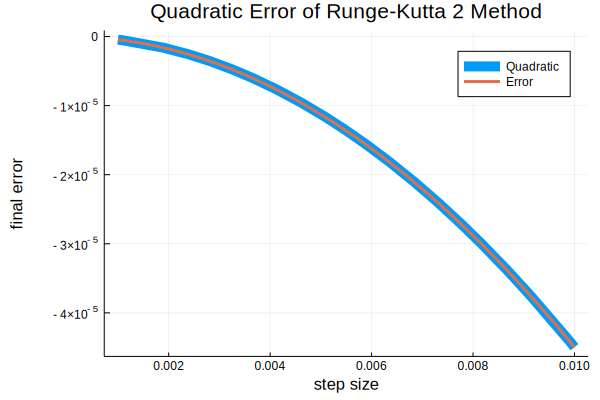

In [15]:
plot(x->errfRK2[end]*(x/.01)^2,dt[1],dt[end],label="Quadratic",
    linewidth=10)
plot!(dt,errfRK2,label="Error",linewidth=3)

plot!(xlabel="step size",ylabel="final error",
    title="Quadratic Error of Runge-Kutta 2 Method")

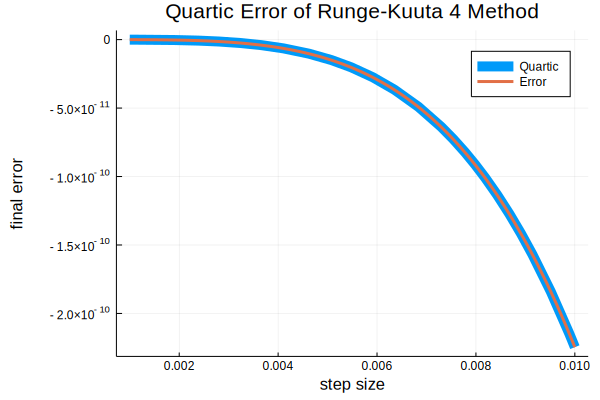

In [16]:
plot(x->errfRK4[end]*(x/.01)^4,dt[1],dt[end],label="Quartic",
    linewidth=10)
plot!(dt,errfRK4,label="Error",linewidth=3)

plot!(xlabel="step size",ylabel="final error",
    title="Quartic Error of Runge-Kuuta 4 Method")

## Arbitrary Order
While I have presented 4 concrete examples, many more exist. For any choice of variables $a_i, \beta_{i,j},a_i$ that fulfill
$$
x_{n+1}=x_n+h\left(\sum_{i=1}^s a_i k_i \right)+ \mathcal{O}(h^p)
$$
with
$$
k_i=f\left(t_n+\alpha_i h,x_n+h\left(\sum_{j=1}^s \beta_{ij} k_j \right) \right)
$$
we have a Runge-Kutta method of order $p$, where $p\geq s$.  The Butcher tableau provides a set of consistent coefficients.

Stay tuned for when we tuned these routines to the stiff van der Pol equations! 